In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from joblib import dump

In [2]:
question_data = pd.read_csv("question_with_text.csv",  sep="\t")

# tidy up city names a bit
question_data['CITY'] = question_data['CITY'].str.replace(r'[^\w\s]+', '')
question_data['CITY'] = question_data['CITY'].str.lower()

# add new column with city & state together
question_data["class_target"] = question_data.CITY.str.cat(question_data.STATE, sep=" ")

In [3]:
# get city + state combos that occur 15+ times
common_cities = question_data.class_target.value_counts()\
    .reset_index(name="count")\
    .query("count > 15")["index"]

common_cities_dataframe = question_data[question_data.class_target.isin(common_cities)]

# remove leaky columns
del common_cities_dataframe["CITY"]
del common_cities_dataframe["STATE"]
del common_cities_dataframe["ZIP"]

In [4]:
dump(common_cities_dataframe.iloc[999], "test_case.joblib.dat")

['test_case.joblib.dat']

In [5]:
# label encode the variables
d = defaultdict(LabelEncoder)

training_data = common_cities_dataframe.\
    apply(lambda x: d[x.name].fit_transform(x))

# test train split
X = training_data.drop(columns='class_target')
y = training_data.class_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

num_class = y.nunique()

In [6]:
np.array(training_data.iloc[999])

array([  0,   2,   8,   1,   7,   4,   3,   6,   7,   4,   3,   3,   4,
         2,   4,   5,   4,   0,   2, 163])

# KNN algo

In [7]:
from sklearn.neighbors import KNeighborsClassifier


In [8]:
# get city + state combos that occur 15+ times
cities = question_data.class_target.value_counts()\
    .reset_index(name="count")\
    .query("count > 3")["index"]

cities_dataframe = question_data[question_data.class_target.isin(cities)]

# remove leaky columns
del cities_dataframe["CITY"]
del cities_dataframe["STATE"]
del cities_dataframe["ZIP"]

# label encode the variables
d_knn = defaultdict(LabelEncoder)

training_data = cities_dataframe.\
    apply(lambda x: d_knn[x.name].fit_transform(x))

##export label encoder "d"
dump(d_knn, "label_encoder.joblib.dat")

# test train split
X_knn = training_data.drop(columns='class_target')
y_knn = training_data.class_target

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.10, random_state=42)

num_class_knn = y_knn.nunique()

In [9]:
## save out the classes for each column encoder
encoder_classes = {}

for key, value in d_knn.items():
    classes = d_knn[key].classes_
    encoder_classes[key] = classes
    
dump(encoder_classes, "encoder_classes.joblib.dat")


['encoder_classes.joblib.dat']

In [10]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)

neigh.fit(X_train_knn, y_train_knn)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [11]:
pred_label = neigh.predict(X_test) 
error_rate = np.sum(pred_label != y_test) / y_test.shape[0]

print(error_rate)

0.9983844911147012


# XGBoost

In [12]:
# convert to XGBoost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [13]:
# train model
param = {'objective':'multi:softmax',
    'num_class':num_class,
    'max_depth':7, 
    'early_stopping_rounds':2}
watchlist = [(dtrain, 'train'), (dtest, 'test')] 
num_round = 13
bst = xgb.train(param, dtrain, num_round, watchlist,
    early_stopping_rounds=2)

[09:49:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.85079	test-merror:0.85662
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 2 rounds.
[1]	train-merror:0.86336	test-merror:0.88368
[2]	train-merror:0.83957	test-merror:0.87157
Stopping. Best iteration:
[0]	train-merror:0.85079	test-merror:0.85662



In [14]:
# convert to XGBoost format
dtrain_bigger = xgb.DMatrix(X_train_knn, label=y_train_knn)
dtest_bigger = xgb.DMatrix(X_test_knn, label=y_test_knn)

# train model
param = {'objective':'multi:softprob',
    'num_class':num_class_knn,
    'max_depth':7, 
    'early_stopping_rounds':2}
watchlist = [(dtrain_bigger, 'train'), (dtest_bigger, 'test')] 
num_round = 13
bst_bigger = xgb.train(param, dtrain_bigger, num_round, watchlist,
    early_stopping_rounds=2)

[09:49:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.92612	test-merror:0.92649
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 2 rounds.
[1]	train-merror:0.95931	test-merror:0.96188
[2]	train-merror:0.95273	test-merror:0.95666
Stopping. Best iteration:
[0]	train-merror:0.92612	test-merror:0.92649



In [15]:
# export bst_bigger model
dump(bst_bigger, "dialect_classifier.joblib.dat")

['dialect_classifier.joblib.dat']

In [16]:
# get prediction
pred = bst_bigger.predict(dtest_bigger)
pred_label = np.argmax(pred, axis=1)
error_rate = np.sum(pred_label != y_test_knn) / y_test_knn.shape[0]
print('Test error using softprob = {}'.format(error_rate))

Test error using softprob = 0.9566648381788261


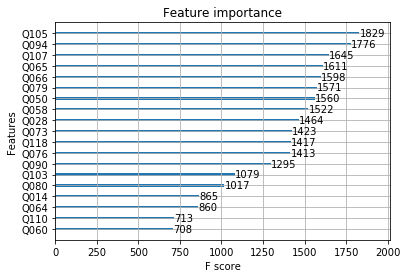

In [17]:
xgb.plot_importance(bst)

In [18]:
cities_dataframe.class_target.value_counts()

chicago IL         921
seattle WA         705
new york NY        662
houston TX         564
kansas city MO     519
                  ... 
chesterfield MI      4
danville IN          4
harrison NY          4
lockport NY          4
glencoe MN           4
Name: class_target, Length: 2127, dtype: int64

# Model evaluation




TODO: 
- Return top three city + state combos 
- Compare to naive benchmark (most common class)
- Export model & encoder
- Convert the user input from Rasa form to correct format for classifier
- Return output as text

In [19]:
pred = bst_bigger.predict(dtest_bigger)

# indexes of the 3 highest prob. classes
top_3 = np.argsort(pred, axis=1)[ : ,-3 : ]

# TODO write function for returning predictions

# calcualte top 3 error
y_test_knn_copy = y_test_knn.reset_index(drop=True)

error_count = 0
for index,value in y_test_knn_copy.items():
    error_count += y_test_knn.iloc[index] not in top_3[index]

print("Top 3 error = ", error_count/ y_test_knn.shape[0])

Top 3 error =  0.9072956664838179
